## Import packages and load data

### import packages

In [ ]:
#Import packages
%reset -f
import pandas as pd
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from ipywidgets import interact, FloatSlider


SyntaxError: unexpected EOF while parsing (80249256.py, line 11)

### Close all figures

In [325]:
plt.close('all')

### load data

In [ ]:

# Load data from Excel files
midfjarnes_filename = '../Data/Miðfjarðnes2022-2023.xlsx'

# Load housing data for Þórshöfn
hus = pd.read_excel('../Data/Thorshofn_Hus.xlsx')

# Filter housing categories of interest
# flokkar_sem_vil = ['Íbúð', 'Íbúð A', 'Íbúð B', 'Verslun', 'Einbýli', 'Skóli', 'Verslun']
# filtered_hus = hus[hus['Lýsing'].isin(flokkar_sem_vil)]

## Nema ég vel bara allt.
filtered_hus = hus
# Read weather observations
t = pd.read_excel(midfjarnes_filename, sheet_name='Veðurathuganir')

# Select relevant columns: time, temperature, wind speed
relevant_columns = ['TIMI', 'T', 'F']
data = t[relevant_columns]

# Extract time, wind speed, and temperature
timi = data['TIMI']
vindhradi = data['F'].values  # Convert to NumPy array
hitastig = data['T'].values  # Convert to NumPy array

### Run this to see useful stuff like unique building types in Þórshöfn data, upplýsingar um veðurstöð, eins og hæð.

In [ ]:
# Read explanations and information about the station
skyringar = pd.read_excel(midfjarnes_filename, sheet_name='Veðurþættir')
upplysingar = pd.read_excel(midfjarnes_filename, sheet_name='Upplýsingar um stöð')
unique_lysing_list = hus['Lýsing'].unique().tolist()
print(skyringar)
print(upplysingar)
print(unique_lysing_list)

   Veðurþáttur                 Útskýring Sjálfvirkar veðurstöðvar
0         STOD                                      Númer stöðvar
1         TIMI                                     Tími athugunar
2           AR                                                 Ár
3          MAN                                            Mánuður
4        DAGUR                                              Dagur
5         KLST                                        Klukkustund
6            T                  Lofthiti (1 mín. meðalgildi) [°C]
7           TX  Hámarkshiti (hæsta 1 mín. meðalgildi á síðustu...
8           TN  Lágmarkshiti (lægsta 1 mín. meðalgildi á síðus...
9           TD                                    Daggarmark [°C]
10          T0                   Veghiti (1 mín. meðalgildi) [°C]
11          RH                   Rakastig (1 mín. meðalgildi) [%]
12           D  Vindátt (10 mín. meðalgildi) [°]. N: 0°, A: 90...
13         ATT                                            Vindátt
14        

# Reikningar

## constants

## Functions o.fl

## Model hot water usage given wind speed and temperature in Flateyri

### Load data

In [ ]:
flateyri_vedur = pd.read_excel(
    '../Data/Flateyri_Vedur.xlsx',
    sheet_name='Veðurathuganir',
    usecols=['DAGS', 'T', 'F']
)
# Extract time, wind speed, and temperature
flateyri_timi = flateyri_vedur['DAGS']
flateyri_vindhradi = flateyri_vedur['F'].values  # Convert to NumPy array
flateyri_hitastig = flateyri_vedur['T'].values  # Convert to NumPy array

flateyri_ketill = pd.read_excel("../Data/Flateyri_ketill_2023.xlsx")
flateyri_hitavatnsnotkun_hourly = flateyri_ketill['Rafskaut Flateyri'].values  #kWh / klst eða kW. Convert to NumPy array 
flateyri_ketill_timi = flateyri_ketill['Datetime']
# Ensure the datetime column is datetime type (just in case))
flateyri_ketill_timi = pd.to_datetime(flateyri_ketill_timi, format='mixed', errors='coerce')
# Trim to a multiple of 24 (optional, if last day is incomplete)
n = (len(flateyri_hitavatnsnotkun_hourly) // 24) * 24
flateyri_hitavatnsnotkun_hourly = flateyri_hitavatnsnotkun_hourly[:n] #kW

# Reshape into (num_days, 24) and average each row
flateyri_hitavatnsnotkun = flateyri_hitavatnsnotkun_hourly.reshape(-1, 24).mean(axis=1) #kWh per day 

# fig, ax = plt.subplots()
# ax.plot(flateyri_hitastig,flateyri_hitavatnsnotkun, label="Flateyri hitavatnsnotkun sem fall af hitastigi", color="b")
# plt.show()

### Create model to predict hot water usage. Linear regression: = a*hitastig + b*vindhradi +c

Removed 1 outliers
Intercept: 3.251, Wind Speed Coefficient: 0.064, Temperature Coefficient: -0.130
R² after removing outliers: 0.693705421665409
Mean Squared Error after removing outliers: 0.20694877367555983


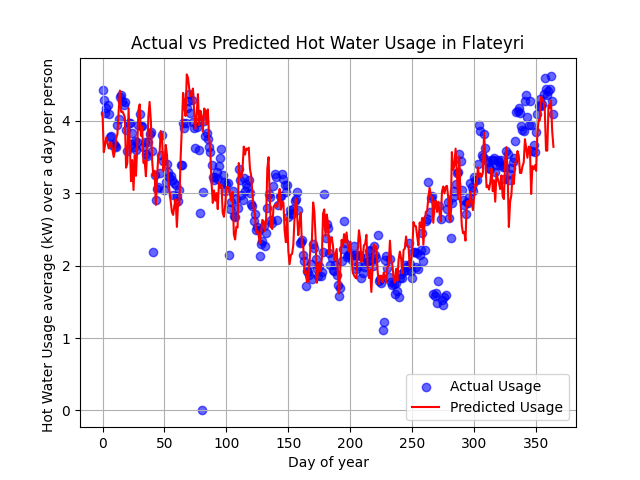

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
X = np.column_stack((flateyri_vindhradi, flateyri_hitastig))  # Features: wind speed and temperature
X = np.column_stack((np.ones(X.shape[0]), X))
y = flateyri_hitavatnsnotkun/189  # Target: hot water usage per person k (189 people in Flateyri)

#IQR til að Fjarlægja outliers
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)

# Calculate IQR
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers by filtering the data within the bounds
filtered_indices = (y >= lower_bound) & (y <= upper_bound)
filtered_y = y[filtered_indices]
filtered_X = X[filtered_indices]
# Check number of outliers removed
print(f"Removed {len(y) - len(filtered_y)} outliers")

# Continue with the model on filtered data
beta = np.linalg.inv(filtered_X.T @ filtered_X) @ filtered_X.T @ filtered_y

# Calculate the new coefficients
intercept = beta[0]
wind_speed_coef = beta[1]
temp_coef = beta[2]
print(f"Intercept: {intercept:.3f}, Wind Speed Coefficient: {wind_speed_coef:.3f}, Temperature Coefficient: {temp_coef:.3f}")
# Predictions on filtered data
y_pred = X @ beta

# Evaluate the model (R² and MSE)
rss = np.sum((y - y_pred)**2)  # Residual Sum of Squares
tss = np.sum((y - np.mean(filtered_y))**2)  # Total Sum of Squares
r_squared = 1 - (rss / tss)

mse = ((y - y_pred)**2).mean()  # Mean Squared Error

# Print evaluation metrics
print(f"R² after removing outliers: {r_squared}")
print(f"Mean Squared Error after removing outliers: {mse}")

# Plot the actual vs predicted values after removing outliers
fig, ax = plt.subplots()
ax.scatter(range(len(y)), y, label='Actual Usage', alpha=0.6, color='blue')
ax.plot(range(len(y)), y_pred, label='Predicted Usage', color='red')
ax.set_xlabel('Day of year')
ax.set_ylabel('Hot Water Usage average (kW) over a day per person ')
ax.set_title('Actual vs Predicted Hot Water Usage in Flateyri')
ax.legend()
ax.grid(True)
plt.show()

### Create model for l/s and t of water in hvolsvöllur, Hella and hvanneyri

#### Load data

In [ ]:
# Gerum ráð fyrir að hiti á affallsvatni sé  Hvanneyri, hella og sámundsstaðir (Hvolsvöllur)
# 1779	Hvanneyri
# 6222	Sámsstaðir
# 6315	Hella

# Load weather data
Hvanneyri_veður = pd.read_excel("../Data/Vedurgögn2022-23.xlsx", sheet_name="Hvanneyri", usecols=['TIMI', 'T', 'F'])
Hvolsvöllur_veður = pd.read_excel("../Data/Vedurgögn2022-23.xlsx", sheet_name="Sámsstaðir", usecols=['TIMI', 'T', 'F'])
Hella_veður = pd.read_excel("../Data/Vedurgögn2022-23.xlsx", sheet_name="Hella", usecols=['TIMI', 'T', 'F'])



In [ ]:
populations = {
    'Hvanneyri': 293,
    'Hvolsvöllur': 1078,
    'Hella': 1015,
    'Flateyri': 189,
    'Þórshöfn': 345
}

bakrásarhitastig = {
    'Hvanneyri': 40,
    'Hvolsvöllur': 32,
    'Hella': 34,
}


In [ ]:
# Load and convert usage data
def load_usage(sheet_name):
    df = pd.read_excel("../Data/HV 2022-24 HVA-HEL-HVO.xlsx", sheet_name=sheet_name)
    df.columns = ['TIMI', 'Rennsli', 'Hiti']  # adjust if actual column names differ
    df['TIMI'] = pd.to_datetime(df['TIMI'], format='mixed', errors='coerce')
    df['kW'] = df['Rennsli'] * 4.186 * (df['Hiti'] - bakrásarhitastig[sheet_name])  # kW
    df['kW'] = df['kW'].clip(lower=0.1)  # Clip values to be above 0
    return df

usage_hella = load_usage("Hella")
usage_hvols = load_usage("Hvolsvöllur")  # Sámsstaðir
usage_hvanneyri = load_usage("Hvanneyri")

# Merge usage with corresponding weather
merged_hella = pd.merge(usage_hella, Hella_veður, on='TIMI', how='inner')
merged_hvols = pd.merge(usage_hvols, Hvolsvöllur_veður, on='TIMI', how='inner')
merged_hvanneyri = pd.merge(usage_hvanneyri, Hvanneyri_veður, on='TIMI', how='inner')

merged_hvanneyri['TIMI'] = pd.to_datetime(merged_hvanneyri['TIMI'])
merged_hvols['TIMI'] = pd.to_datetime(merged_hvols['TIMI'])
merged_hella['TIMI'] = pd.to_datetime(merged_hella['TIMI'])

# Set the 'TIMI' column as the index so I can resample by day later and sum/ average so on

merged_hvanneyri.set_index('TIMI', inplace=True)
merged_hvols.set_index('TIMI', inplace=True)
merged_hella.set_index('TIMI', inplace=True)



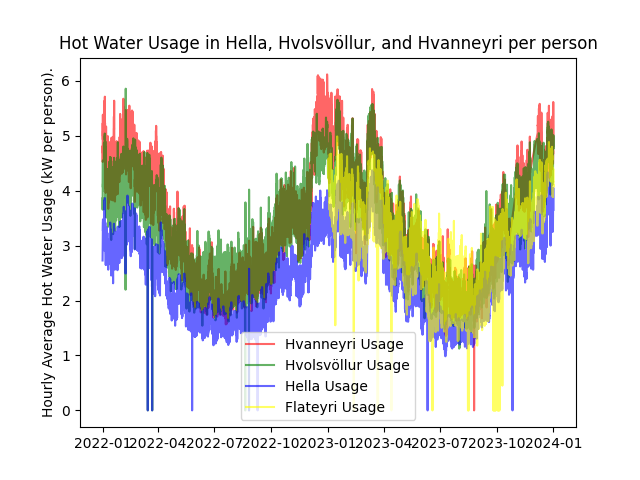

In [ ]:
# make a copy so you don’t overwrite your original
t_2023 = pd.date_range(start="2023-01-01", periods=len(flateyri_hitavatnsnotkun_hourly), freq="H")  # Generate sequential hourly timestamps for 2022
# Ensure 'TIMI' column is in datetime format and set it as the index

fig, ax = plt.subplots()
ax.plot(merged_hvanneyri.index, merged_hvanneyri['kW']/populations['Hvanneyri'], label='Hvanneyri Usage', alpha=0.6, color='red')
ax.plot(merged_hvols.index, merged_hvols['kW']/populations['Hvolsvöllur'], label='Hvolsvöllur Usage', alpha=0.6, color='green')
ax.plot(merged_hella.index, merged_hella['kW']/populations['Hella'], label='Hella Usage', alpha=0.6, color='blue')
ax.plot(t_2023,flateyri_hitavatnsnotkun_hourly/populations['Flateyri'],label = 'Flateyri Usage',alpha = 0.6,color = 'yellow')
ax.set_title('Hot Water Usage in Hella, Hvolsvöllur, and Hvanneyri per person')
ax.set_ylabel('Hourly Average Hot Water Usage (kW per person).')
ax.legend()

plt.show()
# X_hella = np.column_stack((merged_hvols['F'], merged_hvols['T']))  # Features: wind speed and temperature
# X_hella = np.column_stack((np.ones(X_hella.shape[0]), X_hella))
# y_pred_hella = (X_hella @ beta)*1108/380
# fig, ax = plt.subplots()
# ax.plot(range(len(y_hella)), y_hella, label='Actual Usage', alpha=0.6, color='blue')
# ax.plot(range(len(y_hella)), y_pred_hella, label='Predicted Usage', color='red') 
# plt.show()

#### Same as above but daily

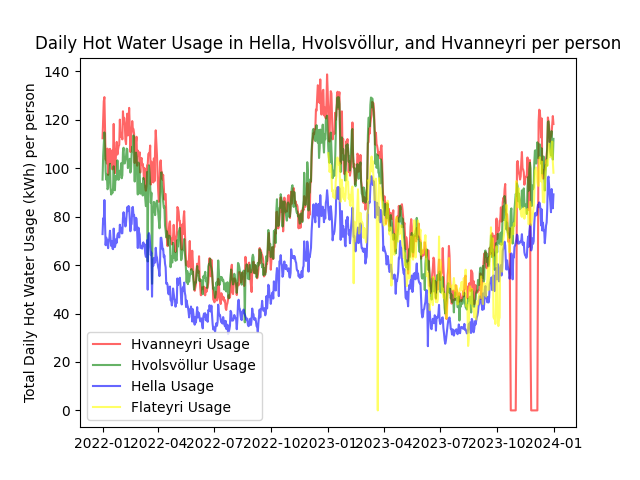

In [ ]:
# Reshape the Flateyri data into daily chunks (assuming 24 hours per day)
flateyri_daily_usage = flateyri_hitavatnsnotkun_hourly.reshape(-1, 24).sum(axis=1) / populations['Flateyri']

# Adjust the t_2023_daily to match the number of days in the reshaped Flateyri data
t_2023_daily = pd.date_range(start="2023-01-01", periods=len(flateyri_daily_usage), freq="D")

daily_hvanneyri_usage = merged_hvanneyri.resample('D').sum() / populations['Hvanneyri']
daily_hvols_usage = merged_hvols.resample('D').sum() / populations['Hvolsvöllur']
daily_hella_usage = merged_hella.resample('D').sum() / populations['Hella']


# Plot the daily energy usage
fig, ax = plt.subplots()


ax.plot(daily_hvanneyri_usage.index, daily_hvanneyri_usage['kW'], label='Hvanneyri Usage', alpha=0.6, color='red')
ax.plot(daily_hvols_usage.index, daily_hvols_usage['kW'], label='Hvolsvöllur Usage', alpha=0.6, color='green')
ax.plot(daily_hella_usage.index, daily_hella_usage['kW'], label='Hella Usage', alpha=0.6, color='blue')
ax.plot(t_2023_daily, flateyri_daily_usage, label='Flateyri Usage', alpha=0.6, color='yellow')

ax.set_title('Daily Hot Water Usage in Hella, Hvolsvöllur, and Hvanneyri per person')
ax.set_ylabel('Total Daily Hot Water Usage (kWh) per person')
ax.legend()

plt.show()



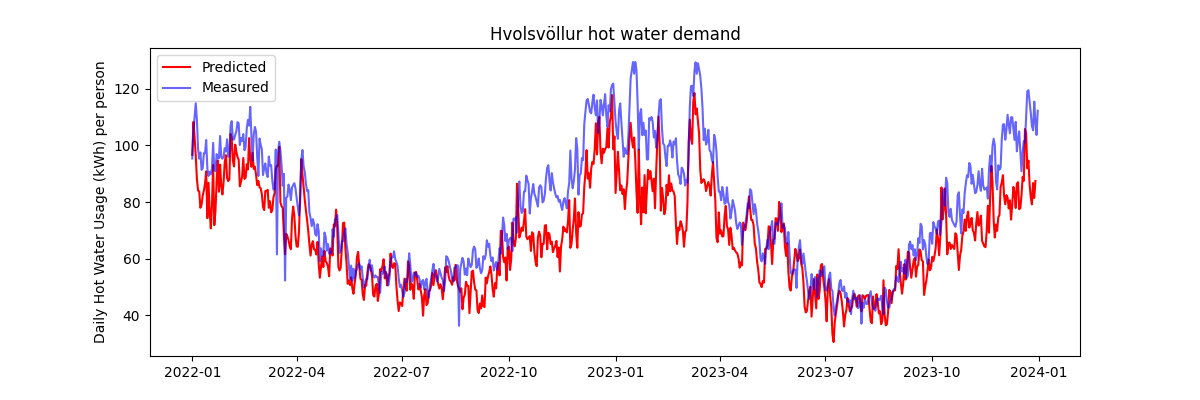

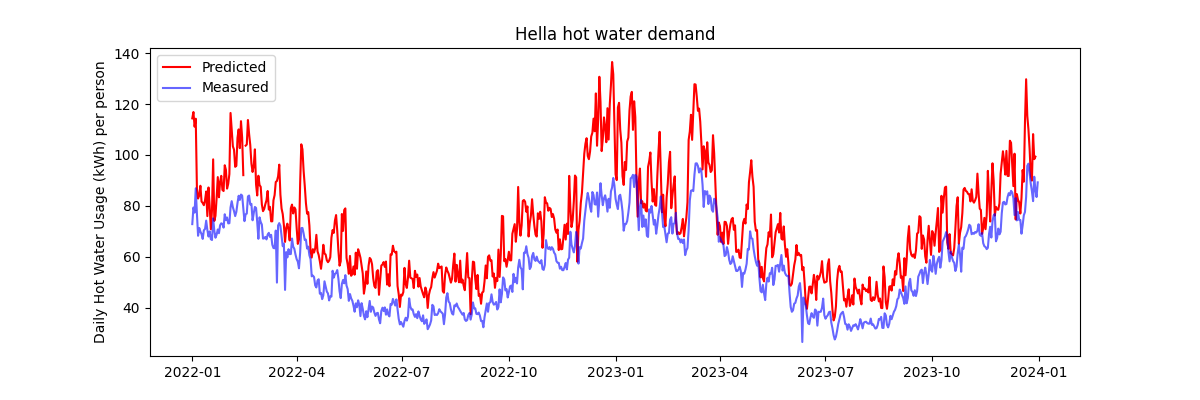

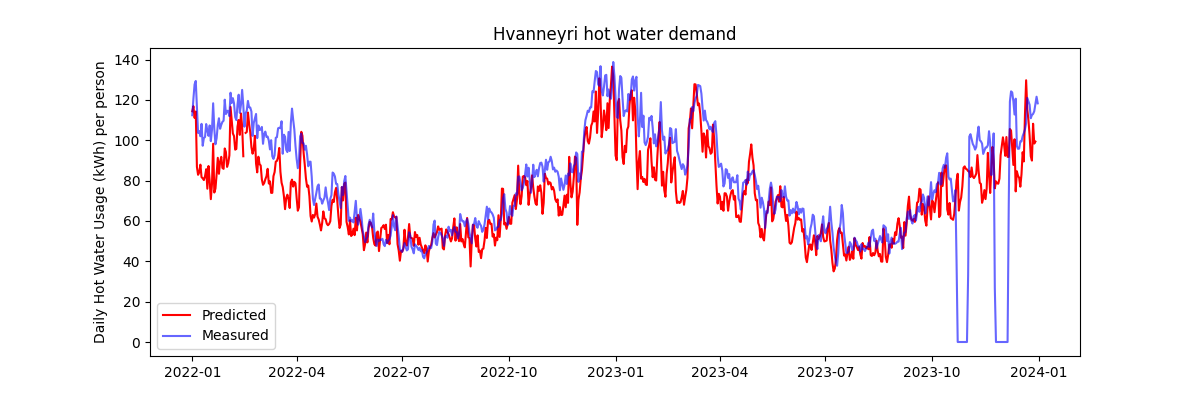

In [303]:
X_hvols = np.column_stack((merged_hvols['F'], merged_hvols['T']))  # Features: wind speed and temperature
X_hvols = np.column_stack((np.ones(X_hvols.shape[0]), X_hvols))
y_hvols_pred = (X_hvols @ beta)
n = (y_hvols_pred.shape[0] // 24) * 24
y_hvols_pred = y_hvols_pred[:n].reshape(-1, 24).sum(axis=1)   # Reshape to daily usage

X_hella = np.column_stack((merged_hella['F'], merged_hella['T']))  # Features: wind speed and temperature
X_hella = np.column_stack((np.ones(X_hella.shape[0]), X_hella))
y_hella_pred = (X_hella @ beta)
n = (y_hella_pred.shape[0] // 24) * 24
y_hella_pred = y_hella_pred[:n].reshape(-1, 24).sum(axis=1)   # Reshape to daily usage

X_hvanneyri = np.column_stack((merged_hella['F'], merged_hella['T']))  # Features: wind speed and temperature
X_hvanneyri = np.column_stack((np.ones(X_hvanneyri.shape[0]), X_hvanneyri))
y_hvanneyri_pred = (X_hvanneyri @ beta)
n = (y_hvanneyri_pred.shape[0] // 24) * 24
y_hvanneyri_pred = y_hvanneyri_pred[:n].reshape(-1, 24).sum(axis=1)   # Reshape to daily usage



fig, ax = plt.subplots(figsize=(12, 4))  
# --- Plot Hvolsvöllur ---
ax.plot(daily_hvols_usage.index[:len(y_hvols_pred)], y_hvols_pred, label='Predicted', color='red')
ax.plot(daily_hvols_usage.index, daily_hvols_usage['kW'], label='Measured', alpha=0.6, color='blue')
ax.legend()
ax.set_title('Hvolsvöllur hot water demand')
ax.set_ylabel('Daily Hot Water Usage (kWh) per person')
plt.show()
# -- Plot Hella ---
fig, ax = plt.subplots(figsize=(12, 4))  
ax.plot(daily_hella_usage.index[:len(y_hella_pred)], y_hella_pred, label='Predicted', color='red')
ax.plot(daily_hella_usage.index, daily_hella_usage['kW'], label='Measured', alpha=0.6, color='blue')
ax.set_title('Hella hot water demand')
ax.set_ylabel('Daily Hot Water Usage (kWh) per person')
ax.legend()
plt.show()
# -- Plot Hvanneyri ---
fig, ax = plt.subplots(figsize=(12, 4))  
ax.plot(daily_hvanneyri_usage.index[:len(y_hvanneyri_pred)], y_hvanneyri_pred, label='Predicted', color='red')
ax.plot(daily_hvanneyri_usage.index, daily_hvanneyri_usage['kW'], label='Measured', alpha=0.6, color='blue')
ax.set_title('Hvanneyri hot water demand')
ax.set_ylabel('Daily Hot Water Usage (kWh) per person')
ax.legend()
plt.show()



### Þórshöfn

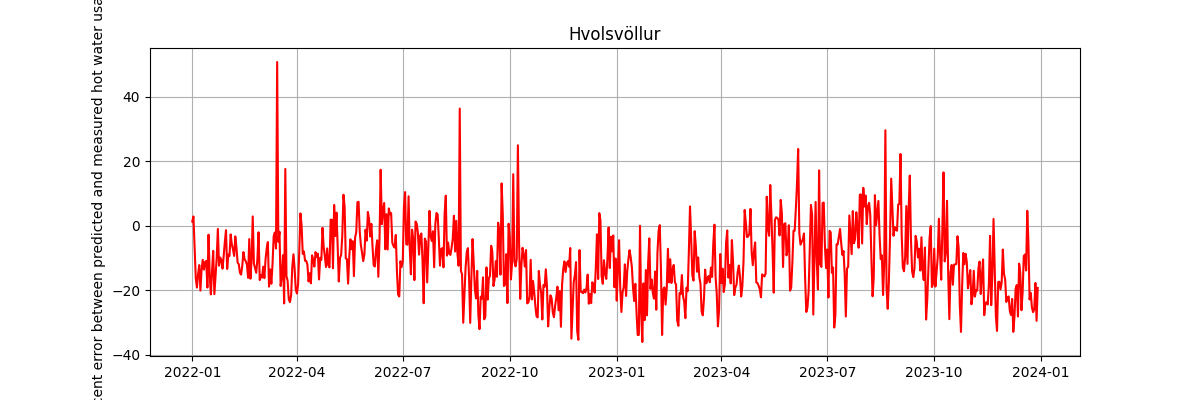

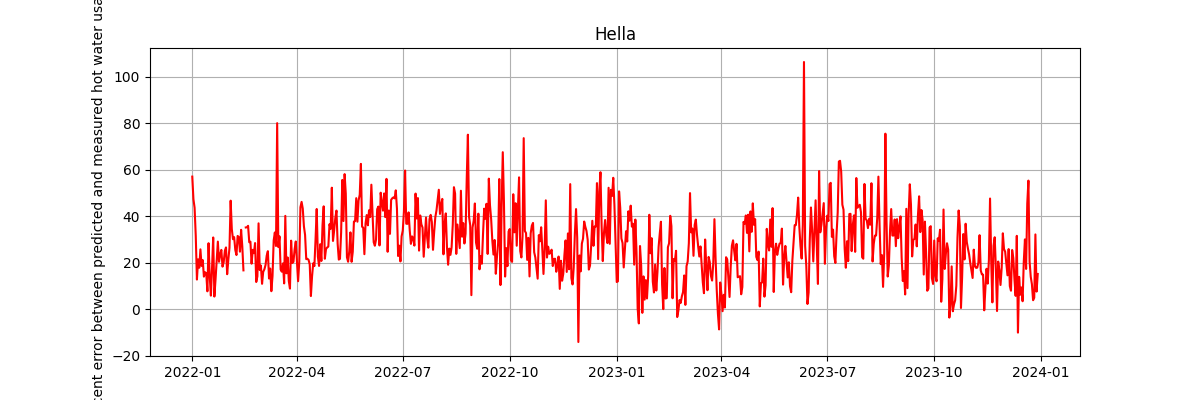

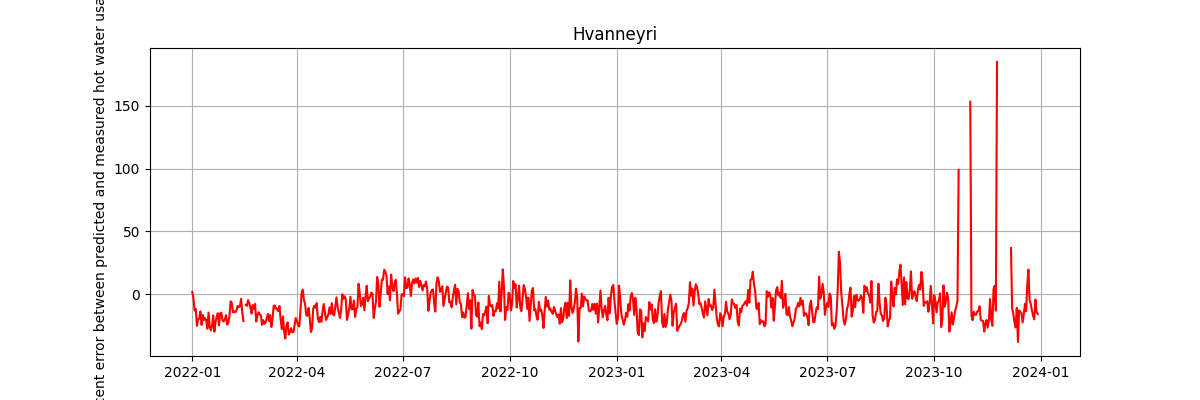

Hella MAPE: 27.97%, Hvolsvöllur MAPE: 13.03%, Hvanneyri MAPE: 13.06%


In [ ]:
hvols_error = 100*(y_hvols_pred-daily_hvols_usage['kW'][:len(y_hvols_pred)])/ daily_hvols_usage['kW'][:len(y_hvols_pred)]
hella_error = 100*(y_hella_pred-daily_hella_usage['kW'][:len(y_hella_pred)])/ daily_hella_usage['kW'][:len(y_hella_pred)]
hvanneyri_error = 100*(y_hvanneyri_pred-daily_hvanneyri_usage['kW'][:len(y_hvanneyri_pred)])/ daily_hvanneyri_usage['kW'][:len(y_hvanneyri_pred)]



fig, ax = plt.subplots(figsize=(12, 4))  
# --- Plot Hvolsvöllur ---
ax.plot(daily_hvols_usage.index[:len(y_hvols_pred)], hvols_error, label='Predicted', color='red')
ax.set_title('Hvolsvöllur')
ax.set_ylabel('Percent error between predicted and measured hot water usage')
ax.grid(True)
plt.show()
# -- Plot Hella ---
fig, ax = plt.subplots(figsize=(12, 4))  
ax.plot(daily_hella_usage.index[:len(y_hella_pred)], hella_error, label='Predicted', color='red')
ax.set_title('Hella')
ax.set_ylabel('Percent error between predicted and measured hot water usage')
ax.grid(True)
plt.show()
# -- Plot Hvanneyri ---
fig, ax = plt.subplots(figsize=(12, 4))  
ax.plot(daily_hvanneyri_usage.index[:len(y_hvanneyri_pred)], hvanneyri_error, label='Predicted', color='red')
ax.set_title('Hvanneyri')
ax.set_ylabel('Percent error between predicted and measured hot water usage')
ax.grid(True)
plt.show()
hellaMAPE = np.mean(np.abs(hella_error))  # Mean Absolute Percentage Error for Hella
hvolsMAPE = np.mean(np.abs(hvols_error))  # Mean Absolute Percentage Error for Hvolsvöllur
hvanneyriMAPE = np.mean(np.abs(hvanneyri_error[np.isfinite(hvanneyri_error)])) #Removing infinite values since hvolsvöllur measured usage was 0 at some points

 
print(f"Hella MAPE: {hellaMAPE:.2f}%, Hvolsvöllur MAPE: {hvolsMAPE:.2f}%, Hvanneyri MAPE: {hvanneyriMAPE:.2f}%")


In [ ]:
t_daily = timi[::24]


X_thor = np.column_stack((vindhradi, hitastig))  # Features: wind speed and temperature
X_thor = np.column_stack((np.ones(X_thor.shape[0]), X_thor))
y_thor_pred = (X_thor @ beta)*populations['Þórshöfn']
n = (y_thor_pred.shape[0] // 24) * 24
y_thor_pred_daily = y_thor_pred[:n].reshape(-1, 24).sum(axis=1)   # Reshape to daily usage
y_thor_pred_daily_average = y_thor_pred[:n].reshape(-1, 24).mean(axis=1)   # Reshape to daily usage

Text(0, 0.5, 'MWh')

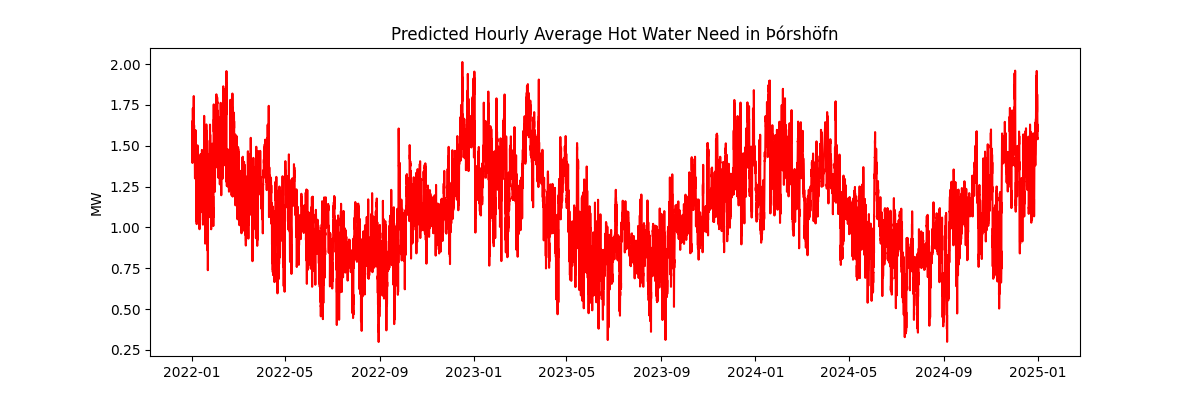

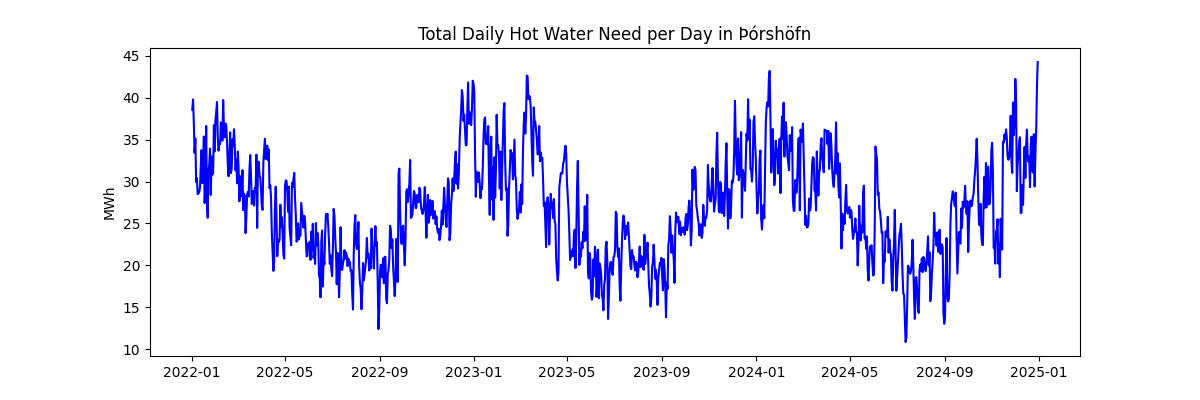

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(timi, y_thor_pred/1000, label='Predicted Usage', color='red')
ax.set_title('Predicted Hourly Average Hot Water Need in Þórshöfn')
ax.set_ylabel('MW')
fig,ax = plt.subplots(figsize=(12, 4))
ax.plot(t_daily[:len(y_thor_pred_daily)], y_thor_pred_daily/1000, label='Predicted Daily Usage', color='blue')
ax.set_title('Total Daily Hot Water Need per Day in Þórshöfn')
ax.set_ylabel('MWh')

# Windmill stuff

#### Function definition wind turbine power

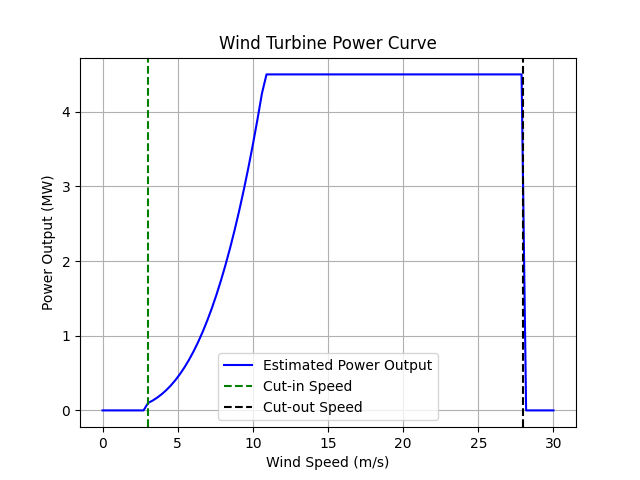

In [ ]:
# Constants
desired_temp = 20  # °Celsius
measurement_height = 25  # meters (upplýsingar um stöð sheet)

# Calculate temperature difference
deltaT = desired_temp - hitastig

# Energy need for heating (simplified) skv orkusetri https://orkusetur.is/hushitun/
hot_water_for_heating = 67  # kWh / m^3 / year
# https://www.veitur.is/hollrad-um-heitt-vatn
# 90% of that is used for heating, so 
energy_need = hot_water_for_heating/0.9 # kWh / m^3 / year
energy_needSI = energy_need * 1e3 * 60**2  # J/m^3 / year
energy_need_day = energy_needSI / 365  # J/m^3 / day


# Calculate total volume and daily energy demand
heildar_fermetrar = filtered_hus['fermetrar'].sum()
medal_lofthaed = 2.5 # m
heildar_rummal = medal_lofthaed * heildar_fermetrar
heildar_dagleg_orkuthorf = heildar_rummal * energy_need / 365  # kWh
orkuthorf_per_hus = heildar_dagleg_orkuthorf / len(filtered_hus)  # kWh

# Wind turbine power function
def wind_turbine_power(time,v, v_cut_in, v_cut_out, P_rated, A, rho=1.225, Cp=0.4):
    """
    Compute wind turbine power output with de-icing adjustment in winter months.

    Parameters:
    - v: array-like of wind speeds (m/s)
    - v_cut_in: cut-in wind speed (m/s)
    - v_cut_out: cut-out wind speed (m/s)
    - P_rated: rated power (W)
    - A: rotor swept area (m^2)
    - time: pandas DatetimeIndex or Series corresponding to each v
    - rho: air density (kg/m^3)
    - Cp: power coefficient

    Returns:
    - power: array of power outputs (W), adjusted for winter de-icing losses
    """
    v = np.asarray(v)
    power = np.zeros_like(v, dtype=float)
    
    # Calculate available power
    P_available = 0.5 * rho * A * Cp * v**3

    # Determine ramp region
    mask_ramp = (v >= v_cut_in) & (v < v_cut_out)
    power[mask_ramp] = np.minimum(P_available[mask_ramp], P_rated)

    # Apply winter de-icing penalty
    winter_months = [11, 12, 1, 2]  # Nov, Dec, Jan, Feb
    if isinstance(time, pd.Series):
        months = time.dt.month
    elif isinstance(time, pd.DatetimeIndex):
        months = pd.Series(time.month, index=time)
    else:
        raise ValueError("time must be a pandas Series or DatetimeIndex")

    winter_mask = months.isin(winter_months).values
    power[winter_mask] *= 0.895  # Reduce by 10.5%

    return power
    
time_vector = pd.date_range(start='2025-06-01', end='2025-6-30', periods=100) #hef bara sumar mánuði, þarf input fyrir power functionið

# Wind speed vector (0 to 30 m/s)
v_values = np.linspace(0, 30, 100)
P_rated = 4500000  # Rated power in Watts
v_cut_in, v_rated, v_cut_out = 3, 11.3, 32  # Cut-in, rated, and cut-out speeds https://en.wind-turbine-models.com/turbines/2446-vestas-v136-4.5

# Compute power output for each wind speed
power_output = wind_turbine_power(time_vector,v_values, 3, 28, P_rated, 14527)

# Plot the wind turbine power curve
fig, ax = plt.subplots()

# Plot estimated power output
ax.plot(v_values, np.array(power_output) / 1e6, label="Estimated Power Output", color="b")

# Plot vertical lines for cut-in, rated, and cut-out speeds
ax.axvline(3, linestyle="--", color="g", label="Cut-in Speed")
ax.axvline(28, linestyle="--", color="black", label="Cut-out Speed")

# Labels, title, legend, and grid
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power Output (MW)")
ax.set_title("Wind Turbine Power Curve")
ax.legend()
ax.grid()

# Display the figure
# plt.show()

#Function to compute wind speed at a given height z given data on wind speed at heigh z_known, (wind profile power law)
def wind_speed_z(z, z_known, V_known, alpha):
    return V_known * (z / z_known) ** alpha




### Example wind power curve image for report


In [ ]:

# # Wind turbine parameters
# v_cut_in = 3      # Cut-in wind speed (m/s)
# v_rated = 10    # Rated wind speed (m/s)
# v_cut_out = 28    # Cut-out wind speed (m/s)
# P_rated = 4     # Rated power (normalized to 1.0 for simplicity)

# # Create wind speed array
# v = np.linspace(0, 35, 500)  # Wind speeds from 0 to 35 m/s

# # Define power curve
# P = np.piecewise(
#     v,
#     [v < v_cut_in,
#      (v >= v_cut_in) & (v < v_rated),
#      (v >= v_rated) & (v <= v_cut_out),
#      v > v_cut_out],
#     [0,
#      lambda v: P_rated * ((v - v_cut_in) / (v_rated - v_cut_in))**3,
#      P_rated,
#      0]
# )

# # Plot
# fig, ax = plt.subplots(figsize=(8,5))
# ax.plot(v, P, label='Power Curve', color='blue')
# ax.axvline(v_cut_in, color='green', linestyle='--', label='Cut-in speed')
# ax.axvline(v_rated, color='orange', linestyle='--', label='Rated speed')
# ax.axvline(v_cut_out, color='red', linestyle='--', label='Cut-out speed')

# ax.set_xlabel('Wind Speed (m/s)')
# ax.set_ylabel('Power output (MW)')
# ax.set_title('Example Wind Turbine Power Curve')
# ax.grid(True)
# ax.legend()
# plt.show()

### Wind energy potential in Þórshöfn based off of https://en.wind-turbine-models.com/turbines/2446-vestas-v136-4.5

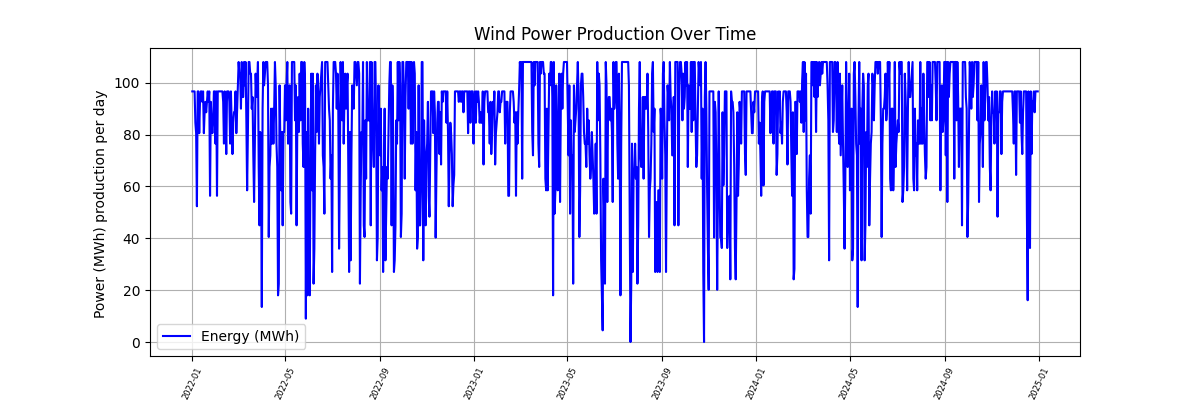

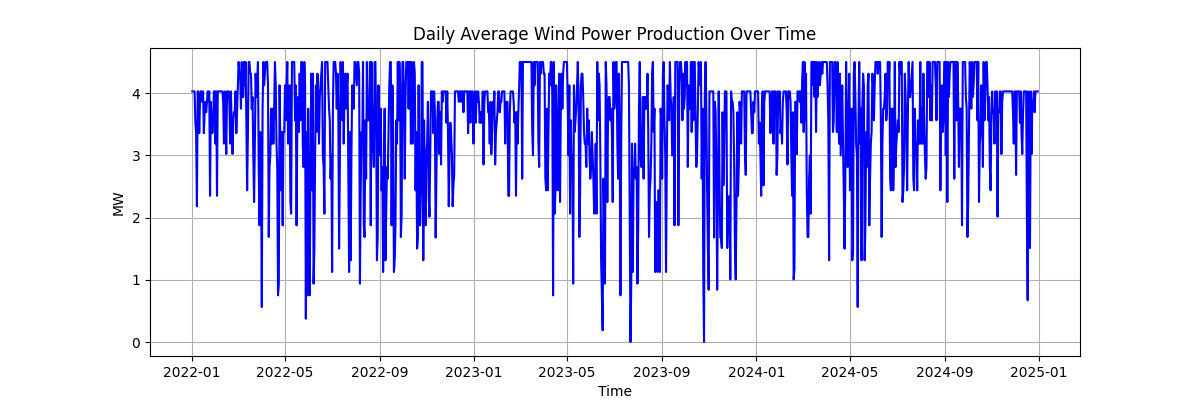

In [ ]:
# Calculate power at each 10-minute interval using the estimated wind speed

V_estimate = wind_speed_z(94,25, vindhradi, 1/7)  # Wind speed at 25m height
V_estimate_trimmed = V_estimate[:24*(len(V_estimate) // 24)]  # Trim to last full day so it's divisible by 24 to get daily averages easily.  
V_estimate_daily = V_estimate_trimmed.reshape(-1, 24).mean(axis=1)  # Daily average wind speed at 25m height
Power_MW = wind_turbine_power(timi,V_estimate, 3, 28, 4.5,14527)

daily_average_MW = Power_MW[:len(Power_MW) // 24*24].reshape(-1, 24).mean(axis=1)  # Daily average power in MW

Power_MW_trimmed = Power_MW[:len(Power_MW) // 24*24]  # Trim to last full day so it's divisible by 24 to get daily averages easily.
daily_MWh = Power_MW_trimmed.reshape(-1, 24).sum(axis=1)


fig, ax = plt.subplots(figsize=(12, 4))

# Plot power in MW by time
ax.plot(t_daily[:len(daily_MWh)], daily_MWh, 'b-', linewidth=1.5, label='Energy (MWh)')

# Labels, title, legend, and grid
ax.set_xlabel('Time')
ax.set_ylabel('Power (MWh) production per day ')
ax.set_title('Wind Power Production Over Time')
ax.legend()
ax.grid(True)


# Rotate x-axis labels and adjust font size
ax.tick_params(axis='x', labelrotation=65, labelsize=6)  # Rotate 45 degrees and reduce font size

# Display the figure
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t_daily[:len(daily_average_MW)], daily_average_MW, 'b-', linewidth=1.5, label='Energy (MWh)')

# Labels, title, legend, and grid
ax.set_xlabel('Time')
ax.set_ylabel('MW')
ax.set_title('Daily Average Wind Power Production Over Time')
ax.grid(True)

plt.show()


# Thermal storage size

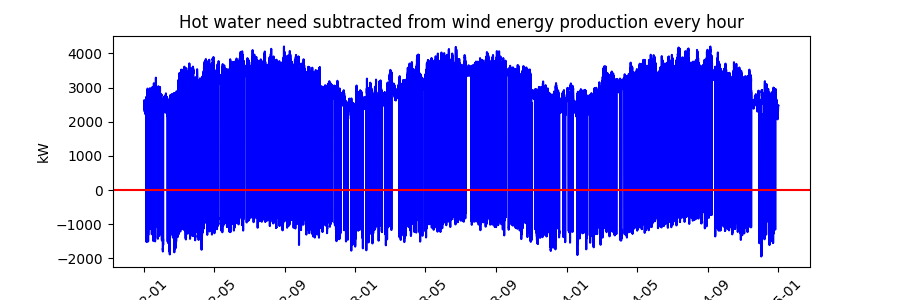

In [ ]:
difference = daily_average_MW*1000-y_thor_pred_daily_average
difference_hour = Power_MW*1000-y_thor_pred
# Calculate the difference between the predicted hot water usage and the wind power production
# This will give you the difference in kWh every hour
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(timi[:len(difference_hour)],difference_hour, label='Hot water need subtracted from wind energy production every hour', color='blue')
ax.set_title('Hot water need subtracted from wind energy production every hour')
ax.axhline(0,color= 'red')
ax.set_ylabel('kW')
plt.xticks(rotation=45)
ax.tick_params(axis='both', labelsize=10)  # <-- Set tick font size here
plt.show()

# #Same but for daily
# fig, ax = plt.subplots(figsize=(9, 3))
# ax.plot(t_daily[:len(difference)],difference, label='Hot water need subtracted from wind energy production', color='blue')
# ax.set_title('Average daily hot water needed subtracted from average daily wind energy production')
# ax.axhline(0,color= 'red')
# ax.set_ylabel('kW')
# plt.show()

## Begin by computing initial thermal storage capacity for recursion. 

Required Thermal Storage Capacity = 41057.10


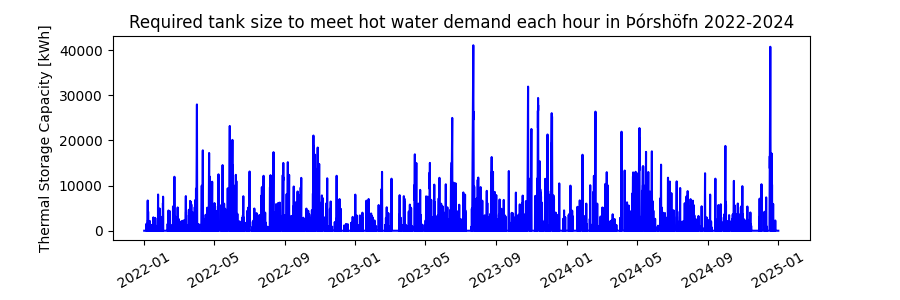

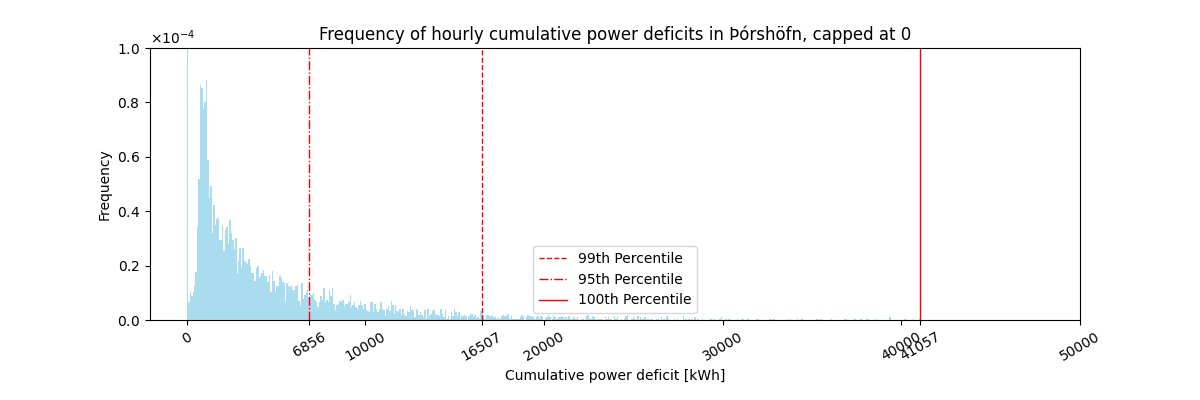

In [361]:
def min_th_storage_capacity(power,usage, hourly_loss = 0.084/100):
    '''
    Simulates thermal storage behavior with hourly energy losses.
    powergen_minus_usage: array of energy surplus/deficit per hour (production - demand), in kWh.
    hourly_loss_fraction: percentage of energy lost per hour, as a decimal (default is 2/24%).

    Returns:
        energy_deficit:  energy deficit over time.
        max_storage_needed: peak energy shortfall that determines minimum required tank size
    '''
    powergen_minus_usage = power - usage  # Calculate surplus/deficit per hour
    required_tank_energy = 0
    energy_deficit = np.zeros_like(powergen_minus_usage)  # Initialize tank levels array

    for i in range(len(powergen_minus_usage)):
        # If tank energy loses 0.084 per hour then it needs to be multiplied with 1/(1-0.084) to withstand the losses
        required_tank_energy *= 1/(1-hourly_loss)  
        # Update tank energy based on surplus/deficit
        required_tank_energy -= powergen_minus_usage[i]  # subtract deficit because negative values are shortages, positive is excess. Positive values are nicer for plotting etc. 
        # Tank can't go below zero
        if required_tank_energy < 0:
            required_tank_energy = 0

        energy_deficit[i] = required_tank_energy
    print(f'Required Thermal Storage Capacity = {max(energy_deficit):.2f}')
    return energy_deficit

energy_deficit = min_th_storage_capacity(Power_MW*1000, y_thor_pred, hourly_loss=0.084/100)
# Plot the cumulative sum of the difference

fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title("Required tank size to meet hot water demand each hour in Þórshöfn 2022-2024")
ax.plot(timi,energy_deficit, label='Cumulative sum of difference', color='blue')
ax.set_ylabel('Thermal Storage Capacity [kWh]')
plt.xticks(rotation=30)
fig.subplots_adjust(bottom=0.2)  # increase bottom margin
plt.show()
ninety_ninth_percentile = np.percentile(energy_deficit,99)
ninety_fifth_percentile = np.percentile(energy_deficit,95)
max_energy_deficit = max(energy_deficit)
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(energy_deficit,bins = 500,density = True, color = 'skyblue', alpha = 0.7)
ax.set_ylim(0, 1e-4)
ax.set_title('Frequency of hourly cumulative power deficits in Þórshöfn, capped at 0')
ax.set_xlabel('Cumulative power deficit [kWh]')
ax.set_ylabel('Frequency')
ax.axvline(ninety_ninth_percentile, color='red', linestyle='dashed', linewidth=1, label='99th Percentile')
ax.axvline(ninety_fifth_percentile, color='red', linestyle='dashdot', linewidth=1, label='95th Percentile')
ax.axvline(max_energy_deficit, color='red', linestyle='solid', linewidth=1, label='100th Percentile')

xticks = sorted([tick for tick in ax.get_xticks() if tick >= 0] + [ninety_ninth_percentile, ninety_fifth_percentile,max_energy_deficit])
ax.set_xticks(xticks)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


ax.legend()
plt.xticks(rotation=30)
fig.subplots_adjust(bottom=0.2)  # increase bottom margin
plt.show()
# or

## Use initial value and do tank simulation, recursively add to storage capacity how much it dips below zero. (This turned out to be pointless)

In [ ]:

def thermal_storage_levels(capacity, power_gen,usage, hourly_loss=0.084/100, initial_level=0):
    """
    Simulates thermal storage behavior with hourly energy losses.
    Parameters:
        capacity: total capacity of the thermal storage in kWh.
        initial_level: initial energy level in the tank in kWh.
        powergen_minus_usage: array of energy surplus/deficit per hour (production - demand), in kWh.
        hourly_loss_fraction: percentage of energy lost per hour, as a decimal (default is 2/24%).
    
    Returns:
        storage_levels: array of energy levels in the tank over time.
    """
    powergen_minus_usage = power_gen - usage 
    storage_levels = np.zeros_like(powergen_minus_usage)  # Initialize tank levels array
    current_level = initial_level

    for i in range(len(powergen_minus_usage)):
        # Apply hourly loss
        current_level *= (1 - hourly_loss)
        # Update tank energy based on surplus/deficit
        current_level += powergen_minus_usage[i]  # add  
        # Ensure tank does not exceed capacity, but I allow it to below zero, because it shouldn't, and I want to check if it does. 
        if current_level > capacity:
            current_level = capacity
        storage_levels[i] = current_level
    minimum_storage_level = min(storage_levels)
    print(f"Minimum storage level = {minimum_storage_level:.2f} kWh")
    return storage_levels, minimum_storage_level


def recursion_true_tank_size(capacity, power_gen, usage, hourly_loss=0.084/100):
    """
    Recursively calculates the minimum tank size needed to meet hot water demand.
    """
    percent_change = 1
    while percent_change > 0.0000001:  # Continue until the change is less than 0.1%
        _, minimum_storage_level = thermal_storage_levels(capacity, power_gen, usage, hourly_loss)
        percent_change = abs(minimum_storage_level / capacity)
        capacity-= minimum_storage_level
    return capacity
recursion_true_tank_size(max_energy_deficit,1000*Power_MW,y_thor_pred)

Minimum storage level = -16.26 kWh
Minimum storage level = -0.66 kWh
Minimum storage level = -0.03 kWh
Minimum storage level = -0.00 kWh


41074.03735516917

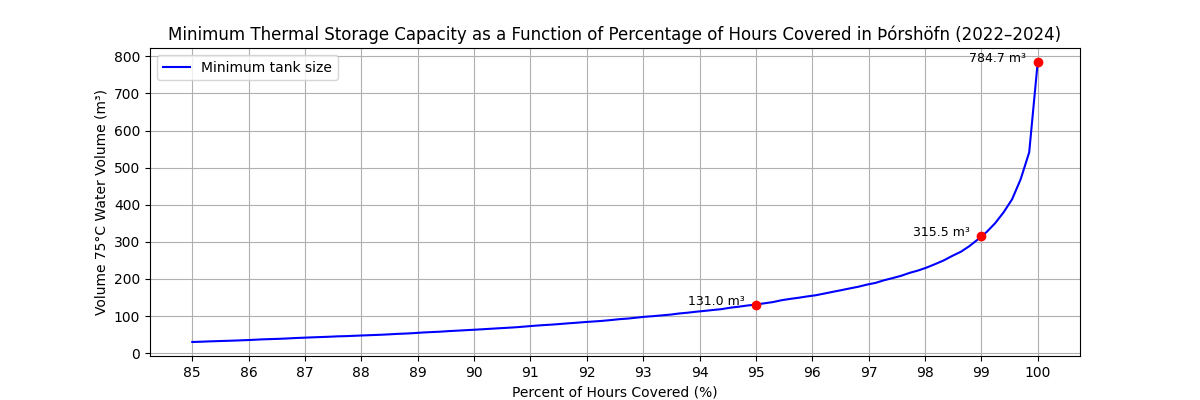

In [342]:
#plota minimum tank size sem fall af desired percentage
def kWh_to_m3(kWh,deltaT):
    """
    Convert kWh to cubic meters of water at a given temperature difference (deltaT).
    1 kWh = 3600 kJ, and the specific heat capacity of water is approximately 4.186 kJ/kg°C.
    The density of water is about 1000 kg/m³.
    """
    return kWh * 3600 / (4.186 * deltaT * 1000)  # Convert kWh to m³

percentiles = np.linspace(85, 100, 100)
min_tank_sizings = np.percentile(energy_deficit, percentiles)
min_tank_sizings_m3 = min_tank_sizings * 3600 / (4.186 * 45 * 1000)  # kWh to m^3

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(percentiles, abs(min_tank_sizings_m3), color='blue', label='Minimum tank size')

# Percentiles to annotate
for p in [95, 99, 100]:
    value = np.percentile(energy_deficit, p)
    value_m3 = value * 3600 / (4.186 * 45 * 1000)
    # Plot dot
    ax.plot(p, abs(value_m3), 'ro')  # red dot
    
    # Annotate
    ax.annotate(f'{abs(value_m3):.1f} m³',
                xy=(p, abs(value_m3)),
                xytext=(p -0.2, abs(value_m3)),
                textcoords='data',
                fontsize=9,
                ha='right')


ax.set_title('Minimum Thermal Storage Capacity as a Function of Percentage of Hours Covered in Þórshöfn (2022–2024)')
ax.set_xlabel('Percent of Hours Covered (%)')
ax.set_ylabel('Volume 75°C Water Volume (m³)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.grid(True)
plt.legend()
plt.show()
   


### Simulate the tank of that capacity to make sure it meets demand

Minimum storage level = -0.9040933543392384 kWh or 0.02 m³


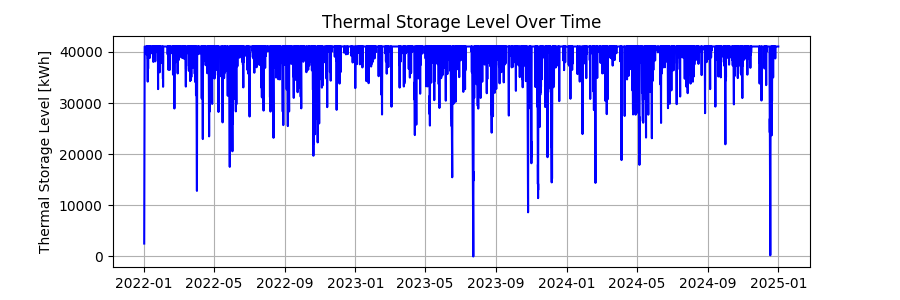

In [ ]:



storage_levels = thermal_storage_level(max_energy_deficit, 1000*Power_MW,y_thor_pred, 0.084/100,0)
fig,ax = plt.subplots(figsize=(9, 3))
ax.plot(timi, storage_levels, label='Thermal Storage Level', color='blue')
ax.set_title('Thermal Storage Level Over Time')
ax.set_ylabel('Thermal Storage Level [kWh]')
ax.grid(True)
plt.show()

## Thermal storage to heat pump power, for percent of scenarios

### Slider plot til að finna minnstu mögulegu heat pump, ef geri ráð fyrir infintie storage fyrir neðra limit á heat pump. Breyti bara slider þangað til að þetta fer ekki niður endalaust. Neglecting losses af því skiptir ekki miklu hér

interactive(children=(FloatSlider(value=1400.0, description='HP_Power', max=1800.0, min=500.0, step=10.0), Out…

<function __main__.update(HP_Power=1400)>

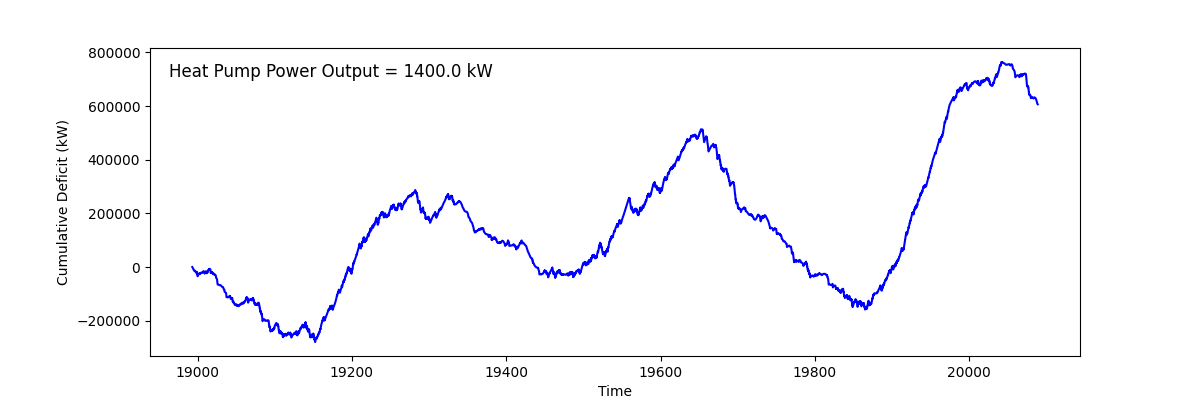

In [347]:
def heat_pump_thermal_output(HP_Power, COP, power_in):
    """
    Calculate the thermal output of a heat pump based on its output power, input wind power and COP .
    
    Parameters:
    - HP_Power: Maximum outputpower to the heat pump (kW).
    - COP: Coefficient of Performance of the heat pump.
    - real_power_in: Wind input power to the heat pump (kW).
    Returns:
    - thermal_output: Thermal output of the heat pump (kW).
    """
    return np.minimum(power_in * COP, HP_Power)

COP = 3

# Plot setup
fig, ax = plt.subplots(figsize=(12, 4))
line, = ax.plot([], [], label='Cumulative Deficit', color='blue')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Deficit (kW)')
text_handle = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top')
def update(HP_Power=1400):
    wind_power_kW = Power_MW * 1000
    HP_output_to_load_deficit = heat_pump_thermal_output(HP_Power, COP, wind_power_kW) - y_thor_pred
    cumulative_deficit = np.cumsum(HP_output_to_load_deficit)
    text_handle.set_text(f"Heat Pump Power Output = {HP_Power} kW")
    line.set_data(timi, cumulative_deficit)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw_idle()

interact(update, HP_Power=FloatSlider(min=500, max=1800, step=10, value=1400))


### Geri svo rest

In [ ]:
def tank_size_for_heat_pump(HP_Power, COP, power_in, hourly_loss=0.084/100,percent_covered=99):
    """
    Calculate the required tank size to meet hot water demand with a heat pump.
    
    Parameters:
    - HP_Power: Maximum output power of the heat pump (kW).
    - COP: Coefficient of Performance of the heat pump.
    - power_in: Wind input power to the heat pump (kW).
    - hourly_loss: Hourly energy loss from the tank (default is 0.084%).
    
    Returns:
    - energy_deficit: Energy deficit over time.
    - max_storage_needed: Peak energy shortfall that determines minimum required tank size.
    """
    thermal_output = heat_pump_thermal_output(HP_Power, COP, power_in)
    powergen_minus_usage = thermal_output - y_thor_pred
    energy_deficit = simulate_tank_with_losses(powergen_minus_usage, hourly_loss)
    
    return np.percentile(energy_deficit,percent_covered)


n_points = 100
HP_power = 1400:
HP_Power = 4500
COP = 3
power_in = Power_MW * 1000  # Convert MW to kW for the input power
hourly_loss=0.084/100
percent_covered=100
tank_size_for_heat_pump(HP_Power, COP, power_in, hourly_loss,percent_covered)

41057.137302986

41057.0953014579